# data set
# data description
**Dataset**t: METABRIC Breast Cancer Clinical Dataset

***Description***:
This dataset contains detailed clinical, pathological, and molecular information for breast cancer patients. Each row represents one patient and includes important medical variables such as tumor size, tumor stage, hormone receptor status, lymph node involvement, gene-expression subtypes, and survival outcomes measured in months.

The dataset combines both clinical features (e.g., age, treatment type) and biological markers (ER/PR/HER2), making it a rich resource for survival prediction and risk modeling.

***Purpose***:
Used to predict long-term breast cancer outcomes. For this project, we convert the survival data into a binary classification target (survive 10+ years vs. not survive).

***Applications***

Clinical risk prediction

Identifying important factors affecting survival

Support for treatment decision-making

Medical ML modeling

**Relevance**:
A widely-used real-world clinical dataset that demonstrates how machine learning can support cancer prognosis, risk prediction, and decision-making in healthcare.

# STEP-1 import ibraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# For handling warnings
import warnings
warnings.filterwarnings('ignore')


# STEP-2 Load Data and Initial Exploration

In [3]:
# Load your METABRIC CSV file
df = pd.read_csv("Breast Cancer METABRIC.csv")  # replace with your file path

# Quick look at the first few rows
print(df.head())

# Basic info about the dataframe
print("\nDataFrame info:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check number of rows and columns
print("\nShape of dataset:", df.shape)

# List all columns
print("\nColumns:")
print(df.columns.tolist())


  Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
0    MB-0000             75.65             Mastectomy  Breast Cancer   
1    MB-0002             43.19      Breast Conserving  Breast Cancer   
2    MB-0005             48.87             Mastectomy  Breast Cancer   
3    MB-0006             47.68             Mastectomy  Breast Cancer   
4    MB-0008             76.97             Mastectomy  Breast Cancer   

                        Cancer Type Detailed Cellularity Chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN           No   
1           Breast Invasive Ductal Carcinoma        High           No   
2           Breast Invasive Ductal Carcinoma        High          Yes   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate          Yes   
4  Breast Mixed Ductal and Lobular Carcinoma        High          Yes   

  Pam50 + Claudin-low subtype  Cohort ER status measured by IHC  ...  \
0                 claudin-low     1.0                   

# Data Cleaning & Missing Values

In [4]:
# Columns to drop
cols_to_drop = [
    'Patient ID',                     # Identifier
    '3-Gene classifier subtype',      # Too many missing
    "Patient's Vital Status",         # Duplicate of survival status
    'Relapse Free Status'             # Not needed if we use Overall Survival
]

# Drop columns
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Check shape and remaining columns
print("Shape after dropping:", df.shape)
print("Remaining columns:", df.columns.tolist())

# Handling missing values
# Option 1: Drop rows with missing outcome (must do)
df = df.dropna(subset=['Overall Survival (Months)', 'Overall Survival Status'])

# Option 2: For other columns, you can either fill or drop depending on percentage missing
# Example: fill numeric columns with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols.remove('Overall Survival (Months)')  # keep duration as-is
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Confirm no missing values left
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Shape after dropping: (2509, 30)
Remaining columns: ['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Sex', 'Tumor Size', 'Tumor Stage']

Missing values after cleaning:
Age at Diagnosis                  0
Type of Breast Surgery            0
Cancer Type                       0
Cancer Type Detailed              0
Cellularity                       0
Chemotherapy                      0
Pam50 + Claudin-low subtype       0
Co

# STEP-3 Exploratory Data Analysis (EDA)

<Figure size 1500x1000 with 0 Axes>

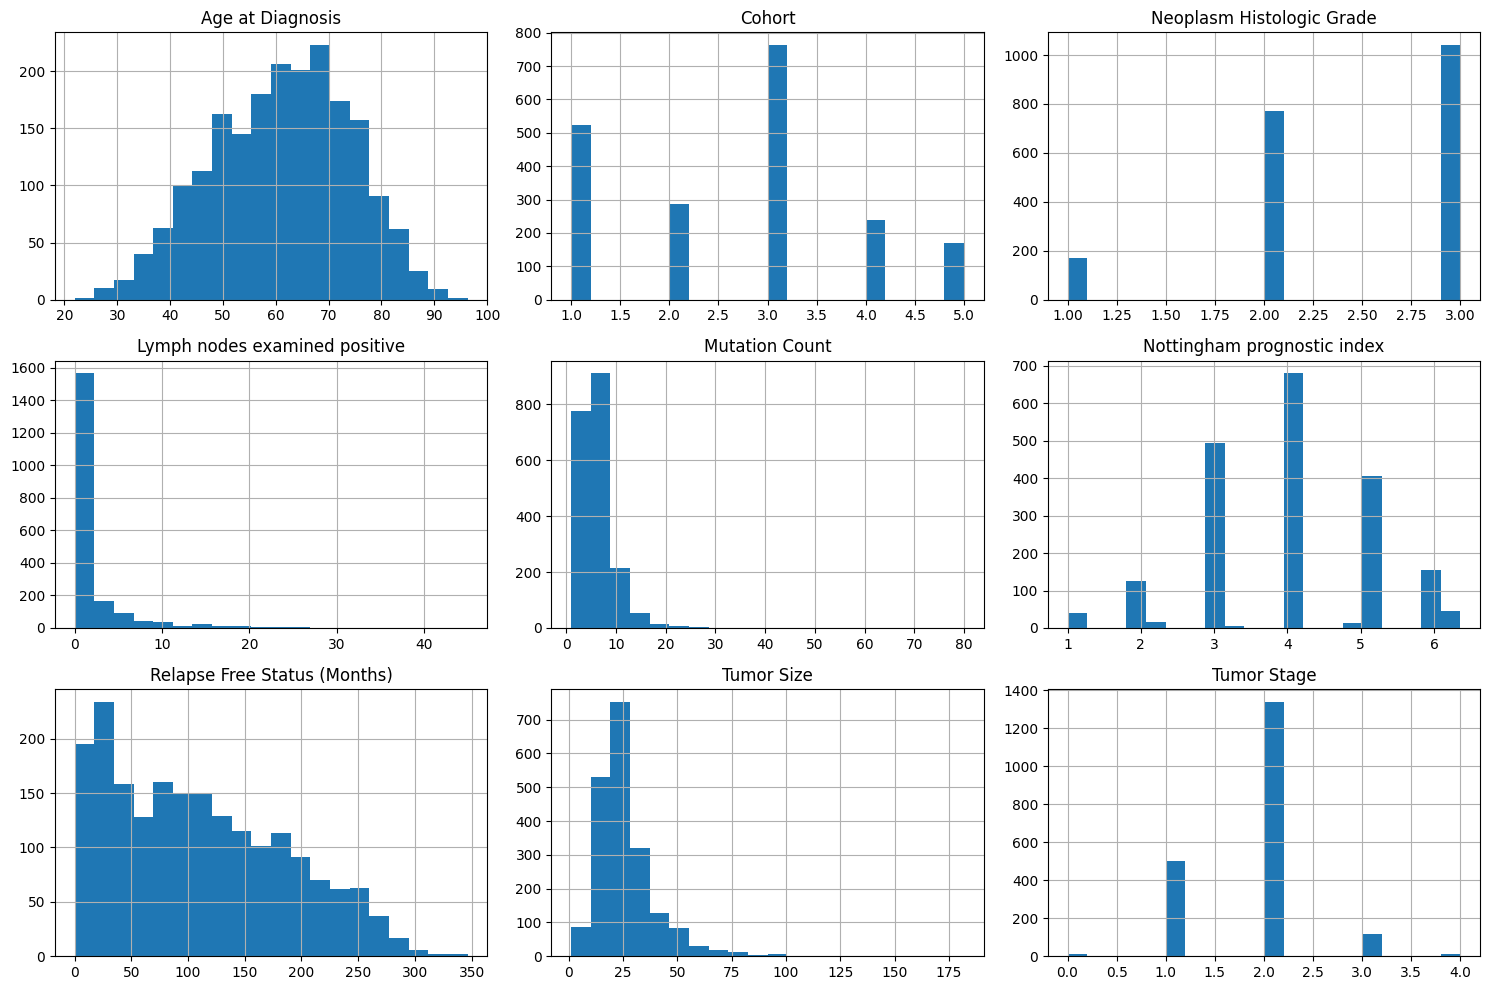

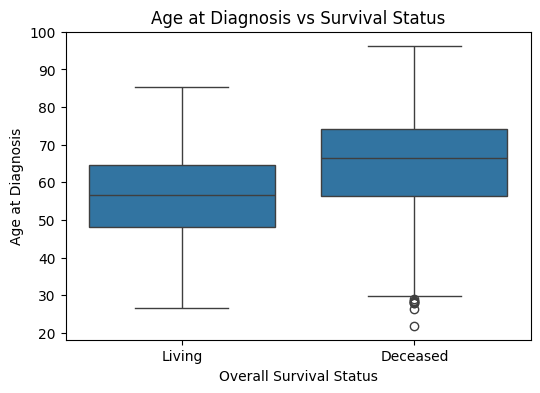

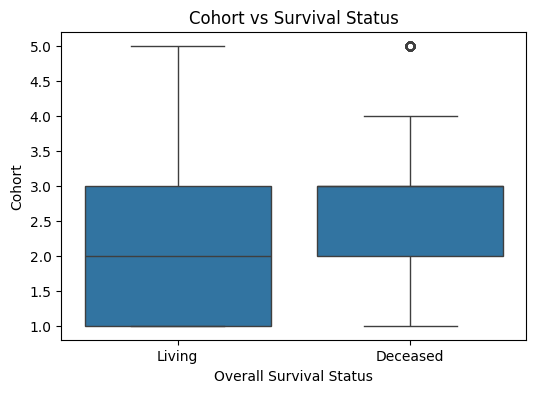

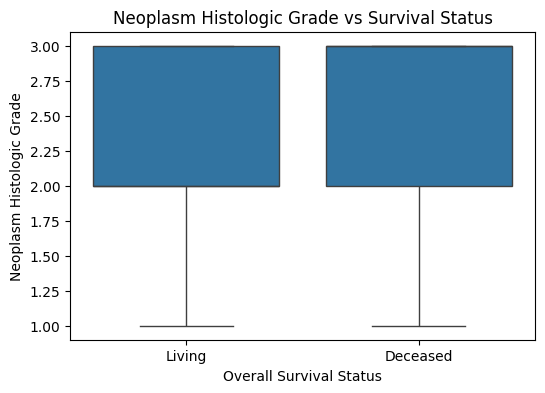

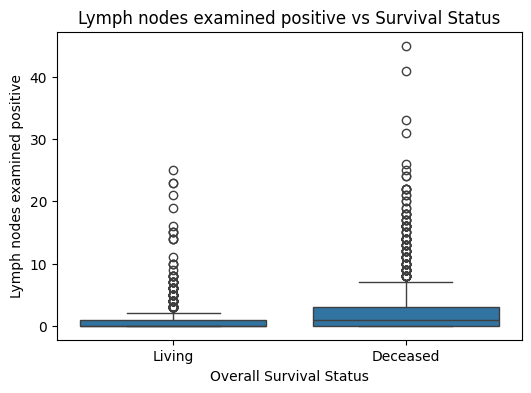

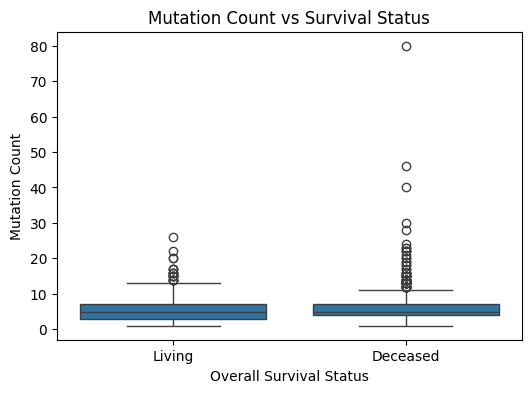

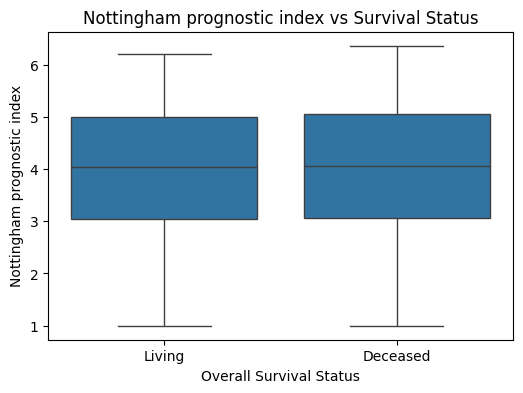

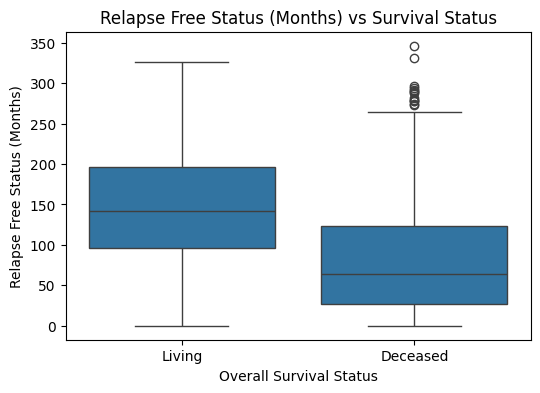

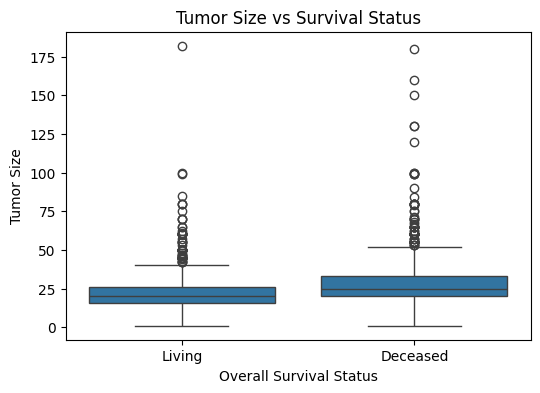

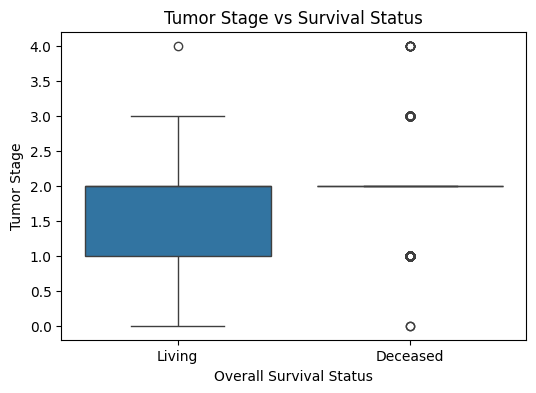

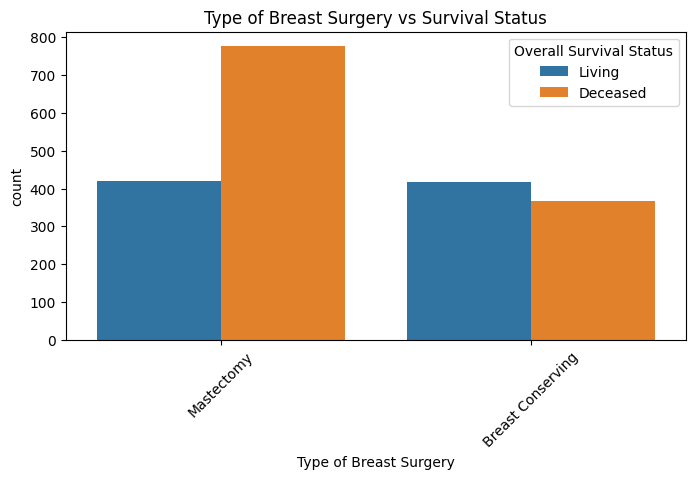

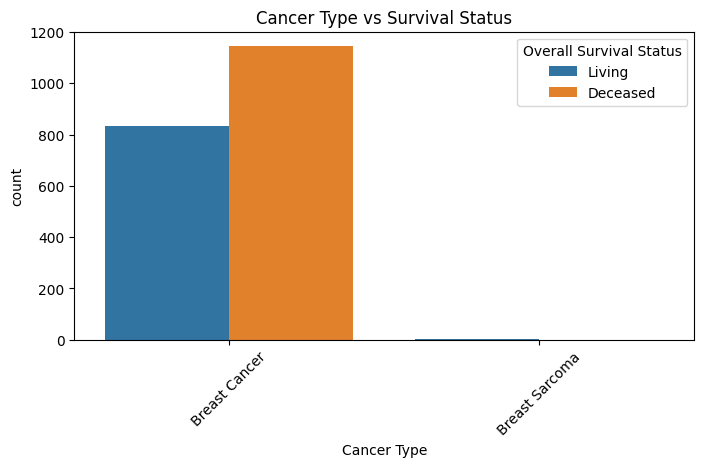

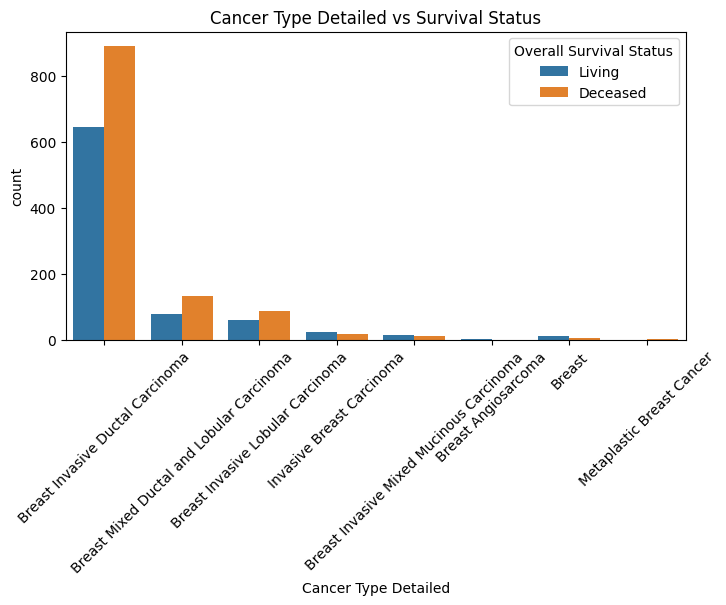

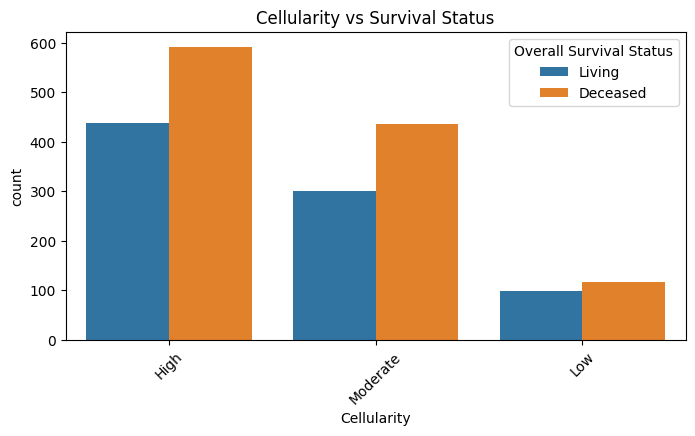

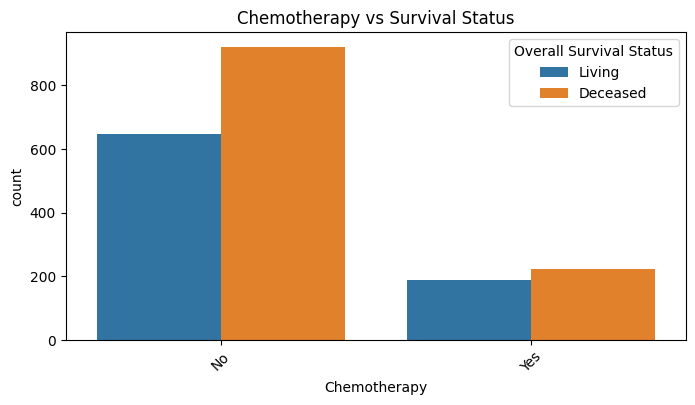

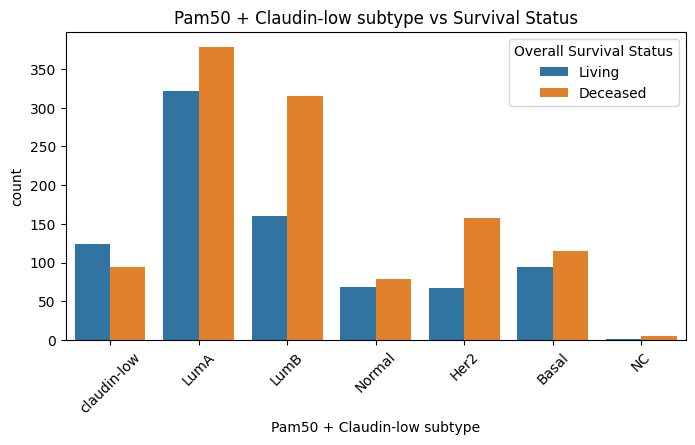

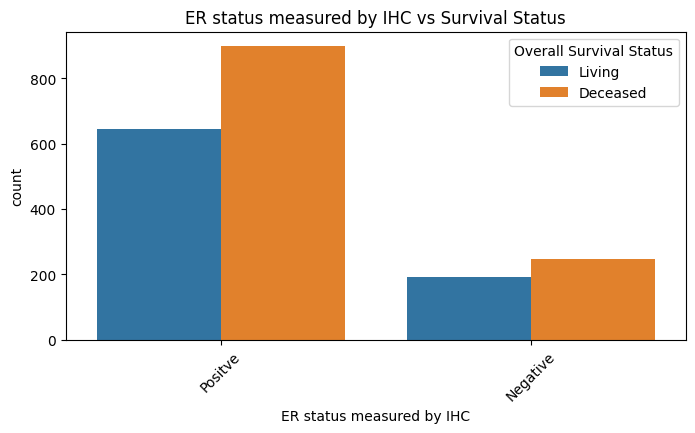

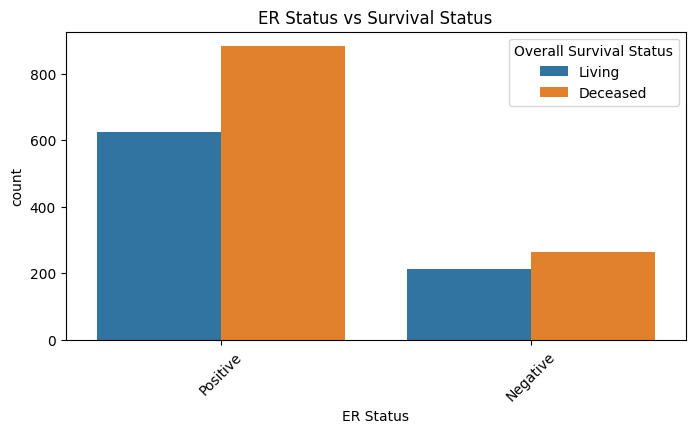

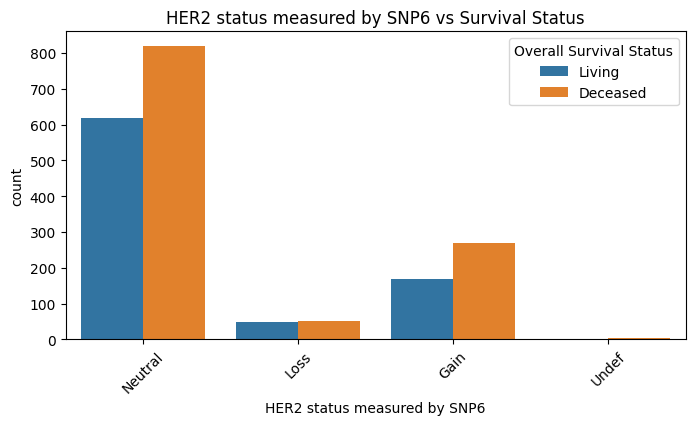

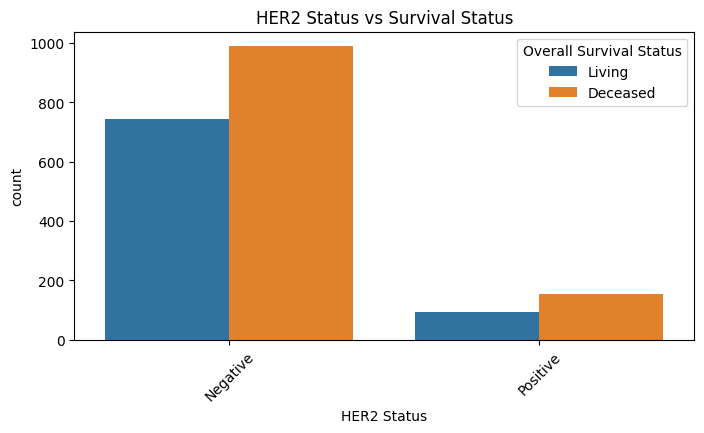

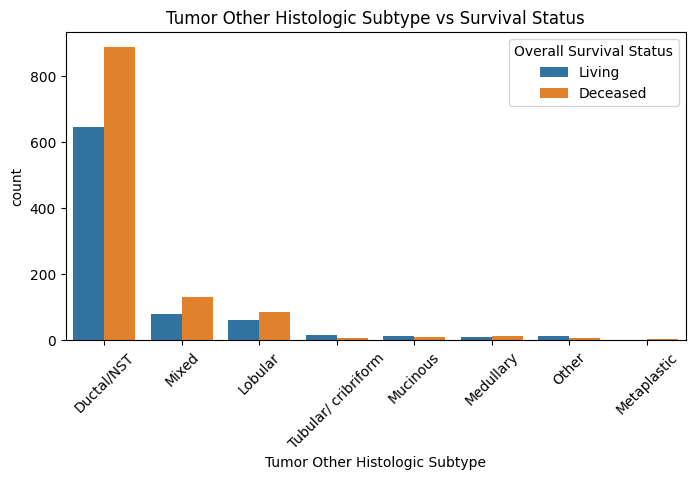

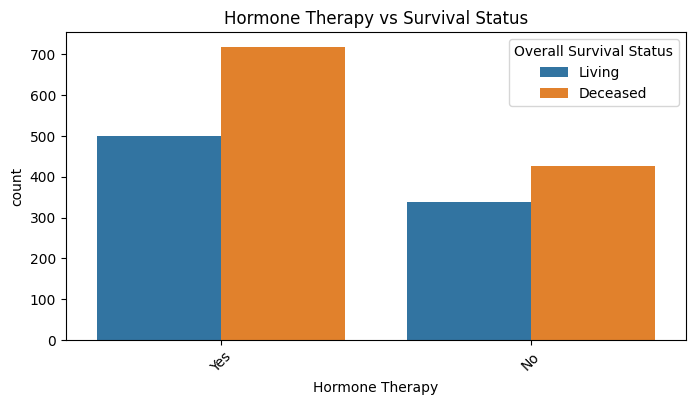

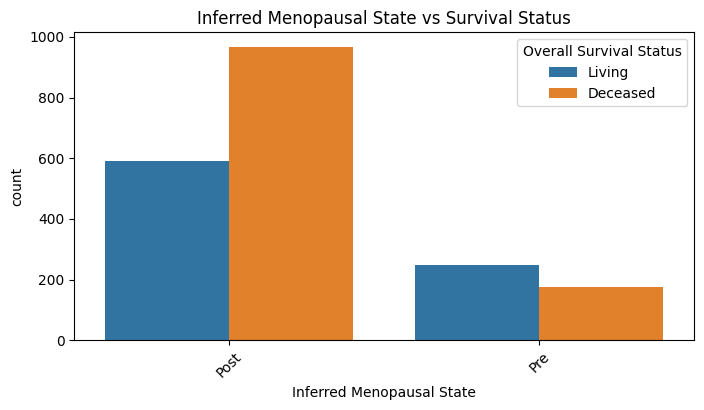

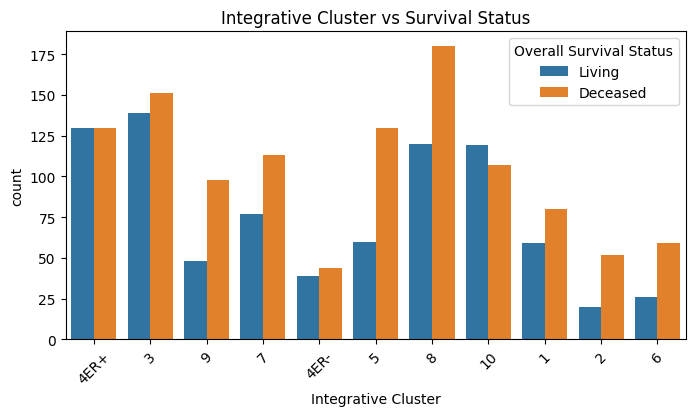

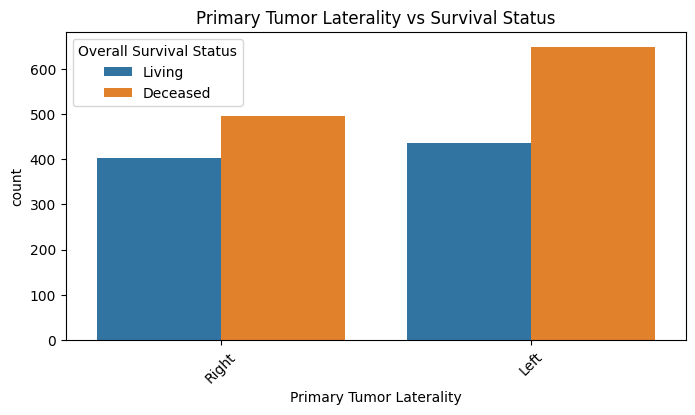

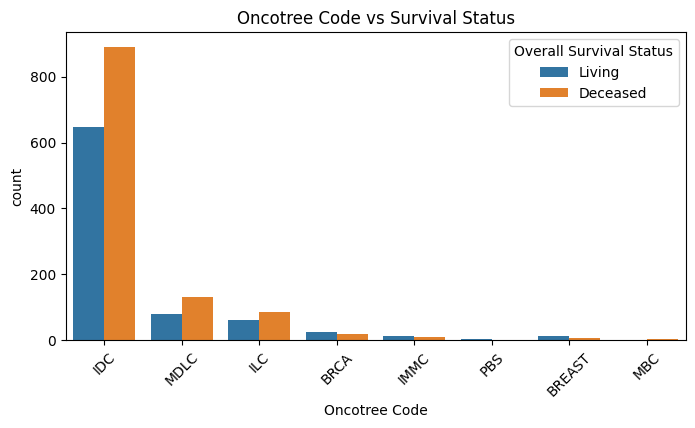

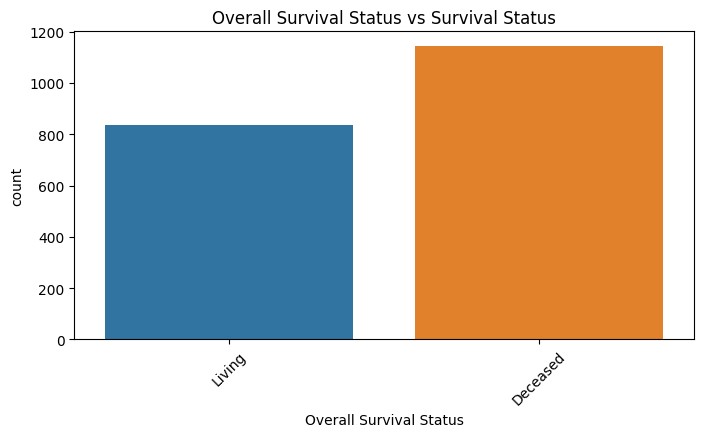

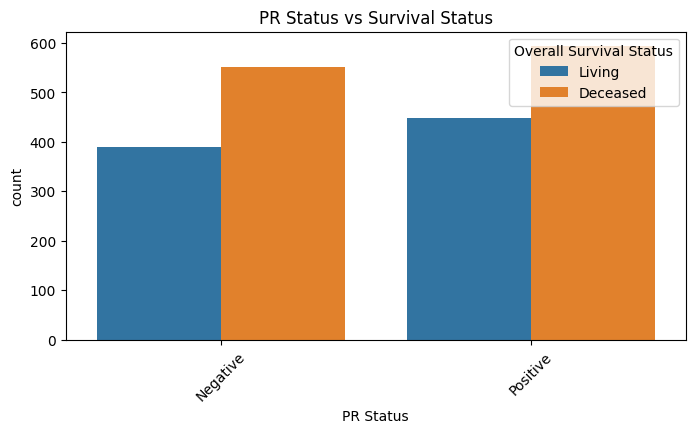

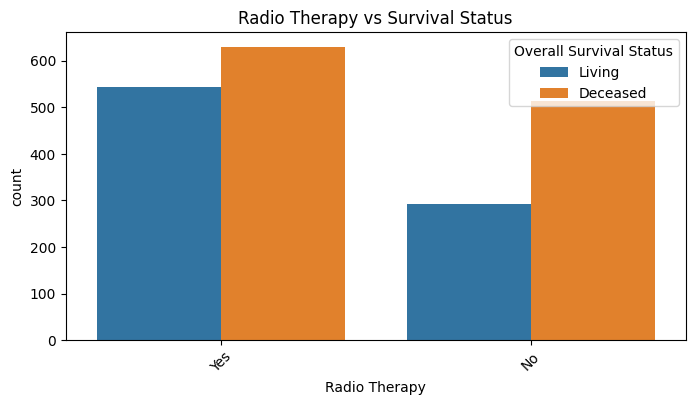

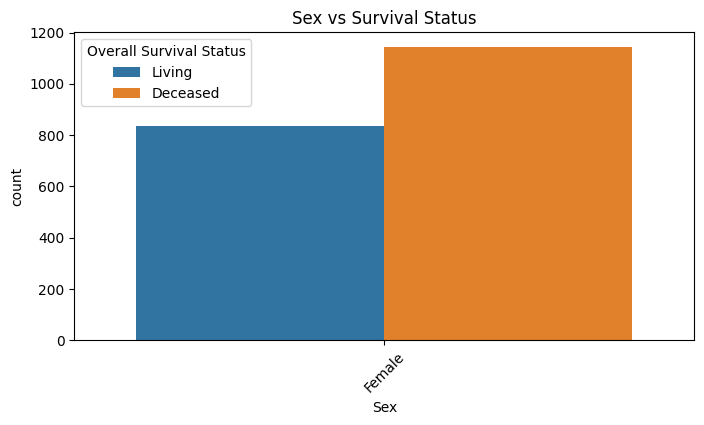

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Numeric Features ---
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude survival columns if present
for col in ['Overall Survival (Months)', 'Overall Survival Status']:
    if col in numeric_cols:
        numeric_cols.remove(col)

# Histograms for numeric features
if numeric_cols:
    plt.figure(figsize=(15,10))
    df[numeric_cols].hist(bins=20, figsize=(15,10))
    plt.tight_layout()
    plt.show()

# Boxplots: Numeric features vs Event (Overall Survival Status)
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Overall Survival Status', y=col, data=df)
    plt.title(f'{col} vs Survival Status')
    plt.show()


# --- Categorical Features ---
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Optional: exclude columns we dropped earlier or survival labels
for col in ['Patient ID', "Patient's Vital Status", '3-Gene classifier subtype']:
    if col in categorical_cols:
        categorical_cols.remove(col)

# Countplots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Overall Survival Status', data=df)
    plt.title(f'{col} vs Survival Status')
    plt.xticks(rotation=45)
    plt.show()


# Numeric Features vs 10-Year Mortality

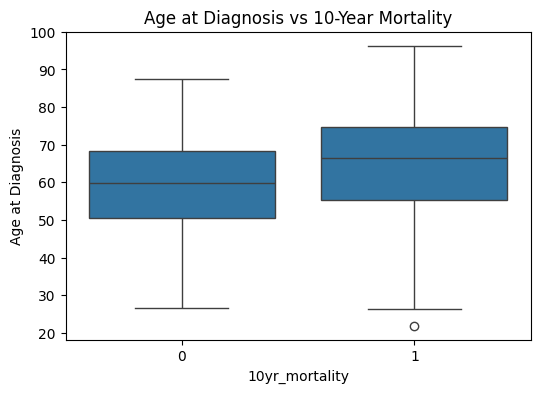

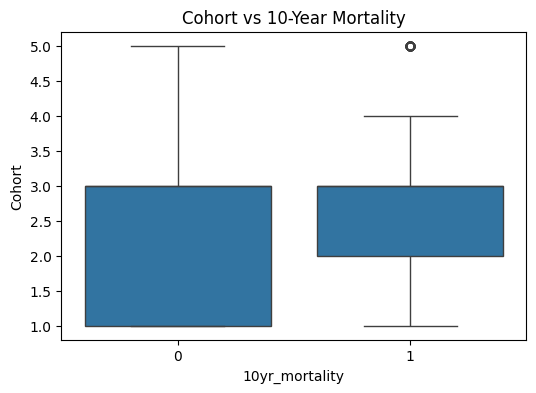

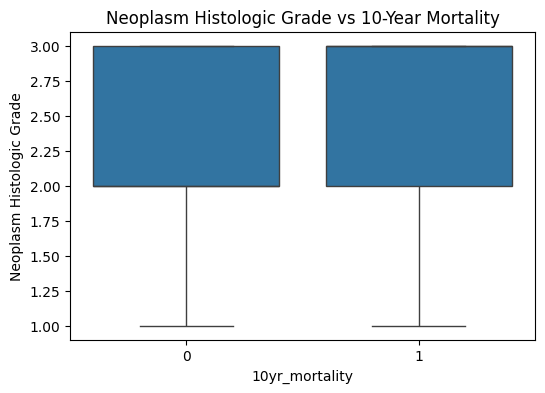

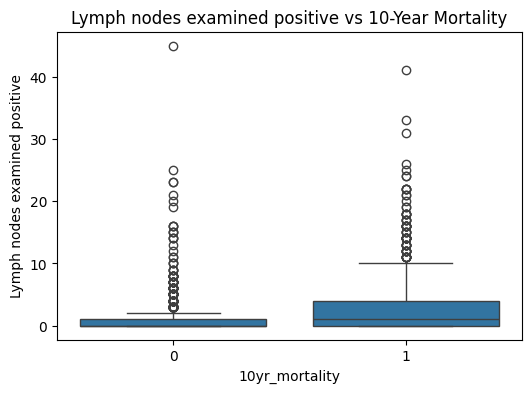

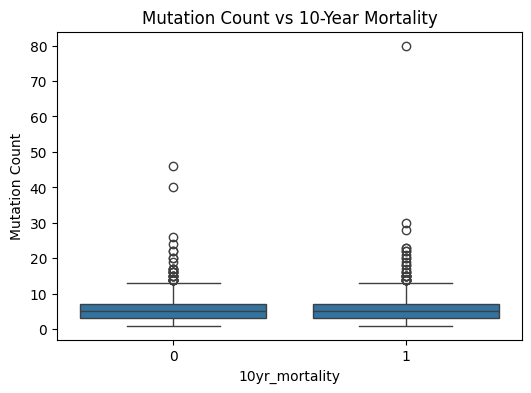

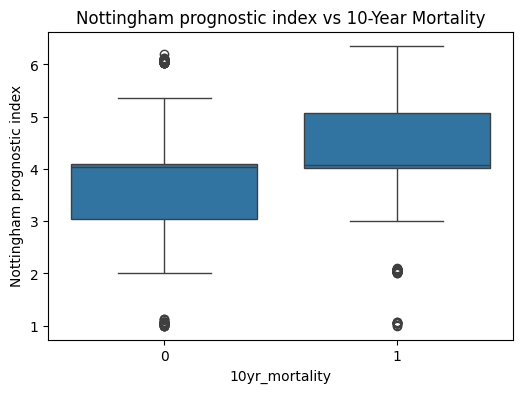

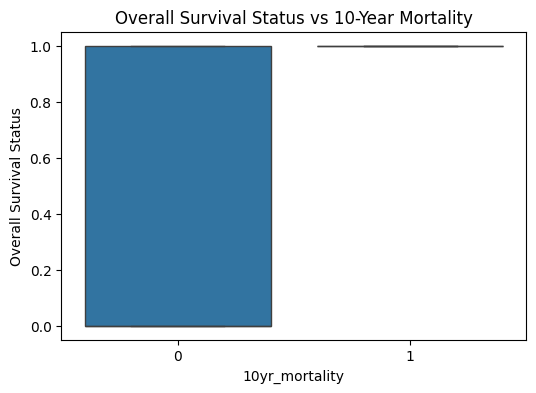

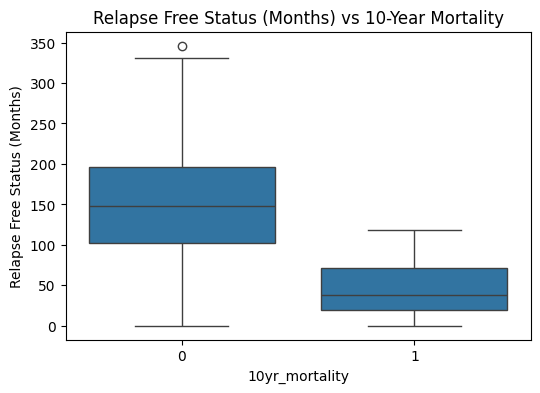

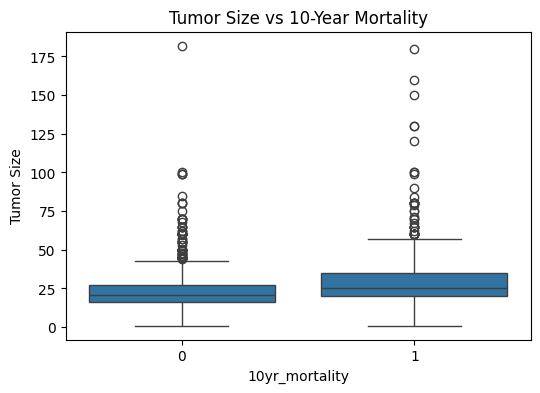

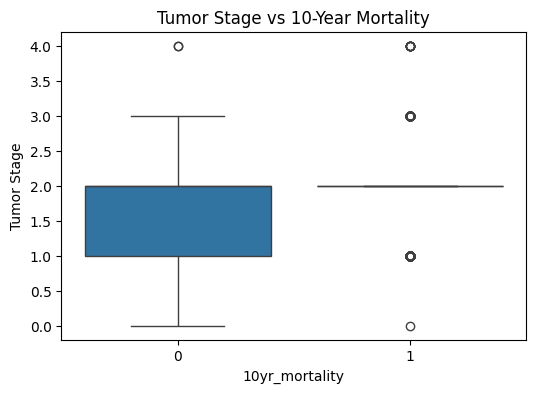

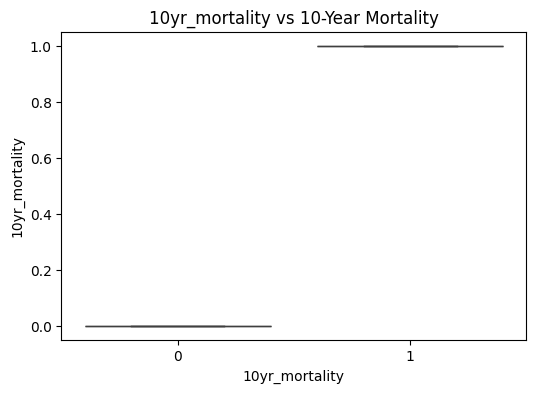

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_cols.remove('Overall Survival (Months)')  # exclude duration

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='10yr_mortality', y=col, data=df)
    plt.title(f'{col} vs 10-Year Mortality')
    plt.show()


# Categorical Features vs 10-Year Mortality

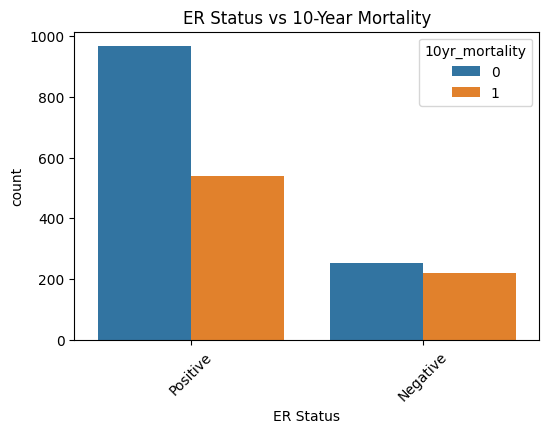

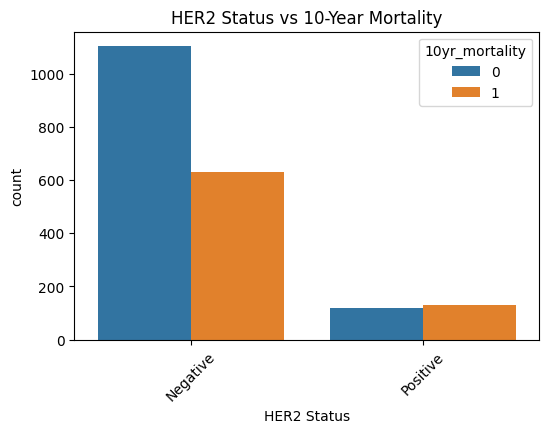

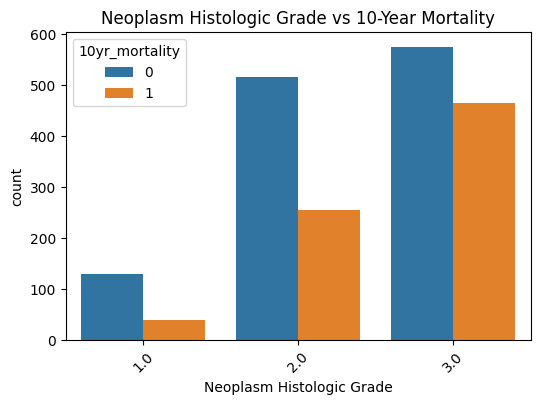

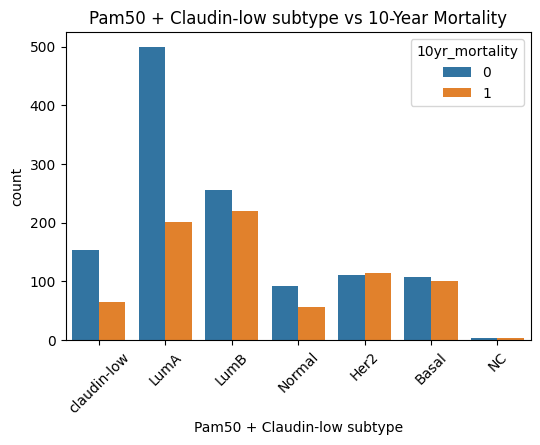

In [20]:
categorical_cols = ['ER Status', 'HER2 Status', 'Neoplasm Histologic Grade', 'Pam50 + Claudin-low subtype']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='10yr_mortality', data=df)
    plt.title(f'{col} vs 10-Year Mortality')
    plt.xticks(rotation=45)
    plt.show()


# Correlation Heatmap

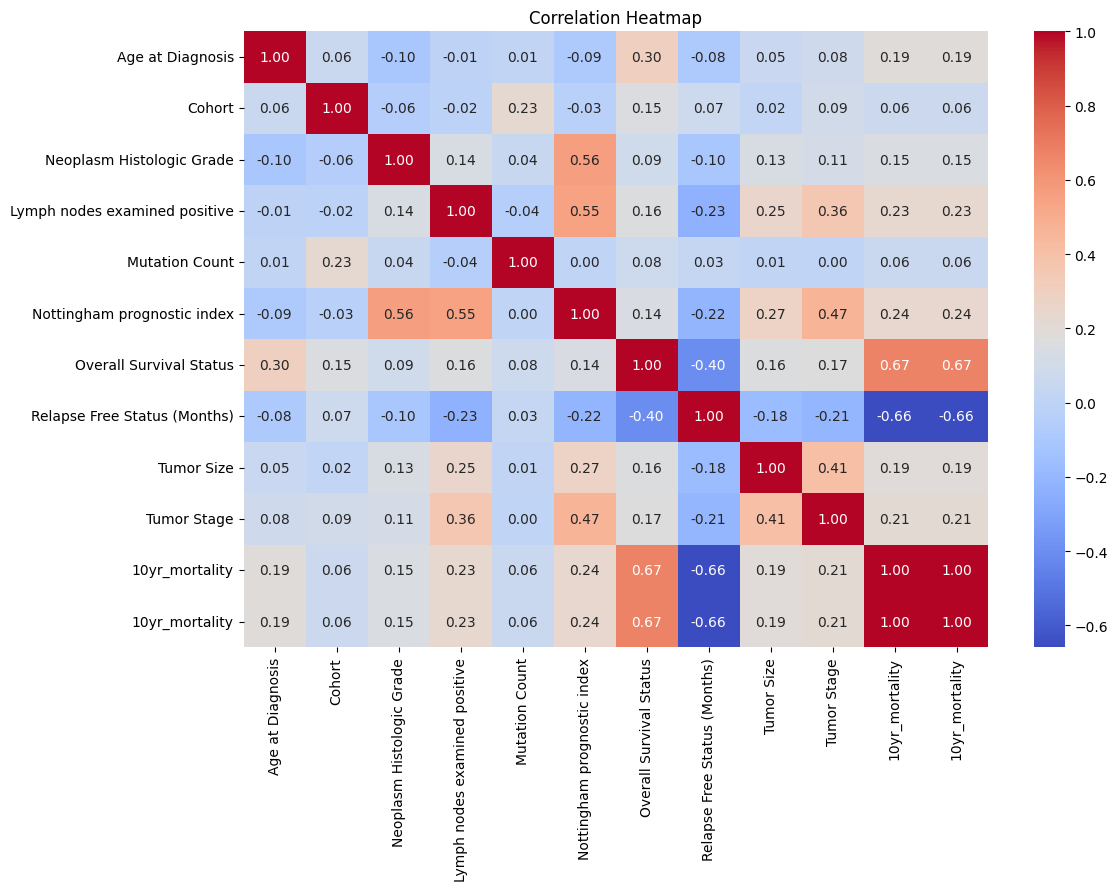

In [21]:
plt.figure(figsize=(12,8))
numeric_cols_corr = numeric_cols + ['10yr_mortality']
sns.heatmap(df[numeric_cols_corr].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# STEP-4 Kaplan-Meier Survival Analysis

Event value counts:
Overall Survival Status
1    1144
0     837
Name: count, dtype: int64


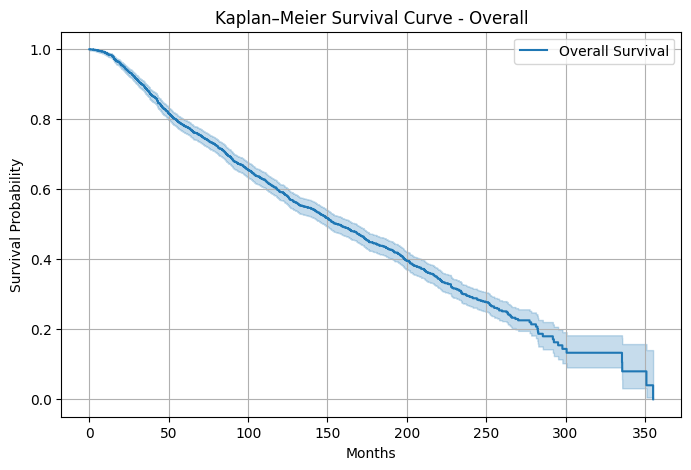

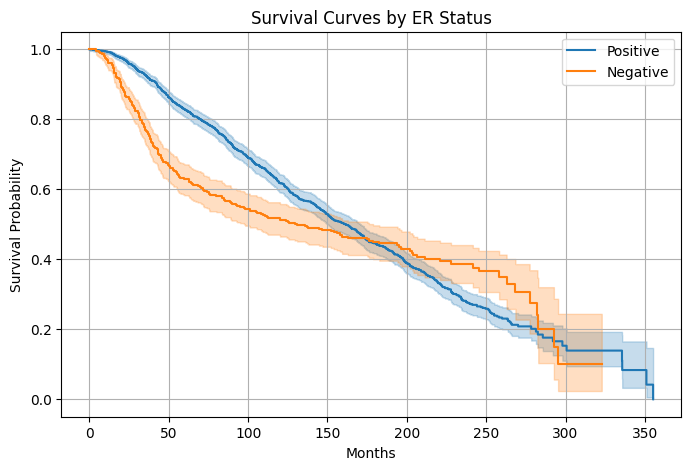

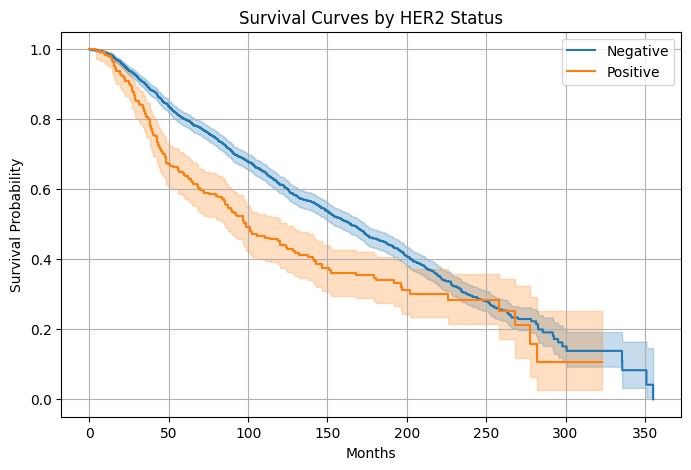

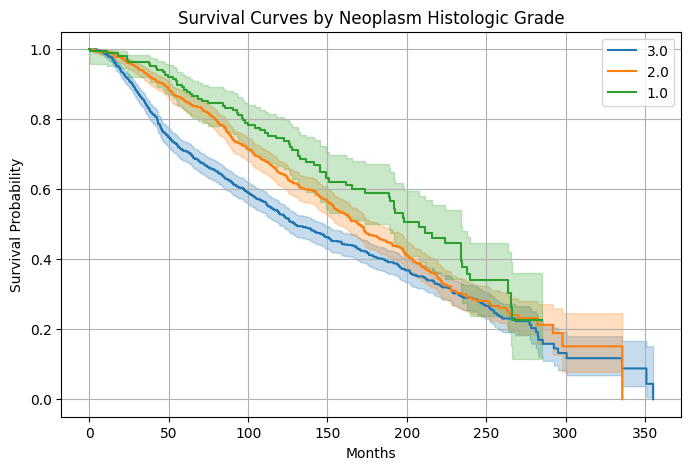

In [6]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# --- Step 5a: Convert event column to numeric ---
# 1 = death, 0 = alive
df['Overall Survival Status'] = df['Overall Survival Status'].map({
    'Deceased': 1,
    'Living': 0
})

# Check conversion
print("Event value counts:")
print(df['Overall Survival Status'].value_counts())

# --- Step 5b: Overall survival curve ---
time = df['Overall Survival (Months)']
event = df['Overall Survival Status']

kmf = KaplanMeierFitter()
kmf.fit(durations=time, event_observed=event, label='Overall Survival')

plt.figure(figsize=(8,5))
kmf.plot()
plt.title("Kaplan–Meier Survival Curve - Overall")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


# --- Step 5c: Survival curves by categorical features ---
categorical_features_to_plot = ['ER Status', 'HER2 Status', 'Neoplasm Histologic Grade']

for col in categorical_features_to_plot:
    if col in df.columns:
        plt.figure(figsize=(8,5))
        for group in df[col].dropna().unique():
            ix = df[col] == group
            # Fit KM for each group
            kmf.fit(time[ix], event[ix], label=str(group))
            kmf.plot_survival_function()
        plt.title(f"Survival Curves by {col}")
        plt.xlabel("Months")
        plt.ylabel("Survival Probability")
        plt.grid(True)
        plt.show()


# STEP-5 Cox Proportional Hazards Model

In [8]:
from lifelines import CoxPHFitter
import pandas as pd

In [9]:
# Remove columns with zero variance
df_encoded = df_encoded.loc[:, df_encoded.var() != 0]

# Optional: remove highly correlated features (correlation > 0.9)
corr_matrix = df_encoded.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_encoded = df_encoded.drop(columns=to_drop)

print("Shape after removing constant/highly correlated features:", df_encoded.shape)


Shape after removing constant/highly correlated features: (1981, 52)


In [10]:
important_cats = ['ER Status', 'HER2 Status', 'Neoplasm Histologic Grade', 'Cancer Type']  
df_cox = df[['Overall Survival (Months)', 'Overall Survival Status'] + important_cats]

# One-hot encode selected categorical features
df_cox_encoded = pd.get_dummies(df_cox, columns=important_cats, drop_first=True)


<lifelines.CoxPHFitter: fitted with 1981 total observations, 837 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival Status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1981
number of events observed = 1144
   partial log-likelihood = -7845.17
         time fit was run = 2025-12-06 06:04:39 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
ER Status_Positive             0.00      1.00      0.07           -0.14            0.14                0.87                1.15
HER2 Status_Positive           0.28      1.32      0.08            0.11            0.44                1.12                1.56
Neoplasm Histologic Grade_2.0  0.05      1.06      0.08           -0.11            0.21                0.90                1.24
Neoplasm Histologic Grade_3.0  0.25      1.28      0.08            0.09            0.41                1.10                1.50
Cancer Type_Breast Sarcoma    -1.09      0.34      1.26           -3.57            1.39                0.03                4.01

                               cmp to     z      p  -log2(p)
covariate                                                   
ER Status_Positive               0.00  0.01   0.99      0.01
HER2 Status_Positive             0.00  3.28 <0.005      9.92
Neoplasm Histologic Grade_2.0    0.00  0.66   0.51      0.97
Neoplasm Histologic Grade_3.0    0.00  3.08 <0.005      8.92
Cancer Type_Breast Sarcoma       0.00 -0.86   0.39      1.36
---
Concordance = 0.57
Partial AIC = 15700.34
log-likelihood ratio test = 30.90 on 5 df
-log2(p) of ll-ratio test = 16.64

<Axes: xlabel='log(HR) (95% CI)'>

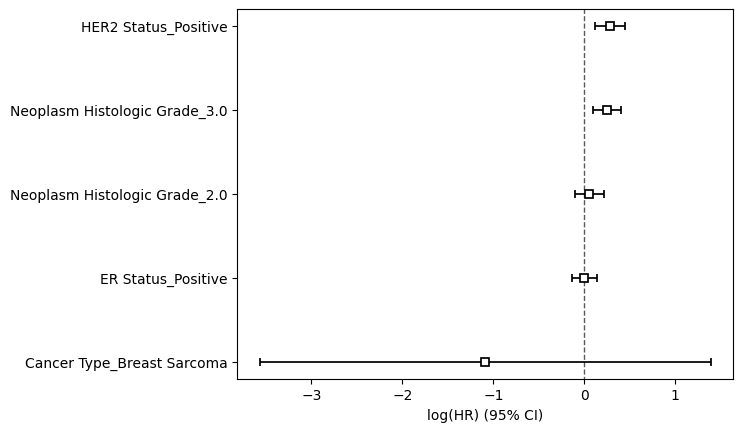

In [11]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # small L2 regularization
cph.fit(df_cox_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

cph.print_summary()
cph.plot()


# STEP-6 Feature Engineering & 10-Year Mortality Target

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Step 7a: Create 10-year mortality label ---
# 10-year = 120 months
df['10yr_mortality'] = ((df['Overall Survival (Months)'] <= 120) & (df['Overall Survival Status'] == 1)).astype(int)

print("10-year mortality counts:")
print(df['10yr_mortality'].value_counts())

# --- Step 7b: Prepare features ---
# Use same features as CoxPH (or all relevant after cleaning)
features = df_encoded.drop(['Overall Survival (Months)', 'Overall Survival Status'], axis=1)
target = df['10yr_mortality']

# Scale numeric features
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[numeric_cols] = scaler.fit_transform(features_scaled[numeric_cols])

# --- Step 7c: Split data ---
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)


10-year mortality counts:
10yr_mortality
0    1221
1     760
Name: count, dtype: int64


# STEP-7 Train & Evaluate ML Models

# 1ST- LOGISTIC REGRESSION 

Logistic Regression Accuracy: 0.7027707808564232
Logistic Regression ROC-AUC: 0.7445220193340494


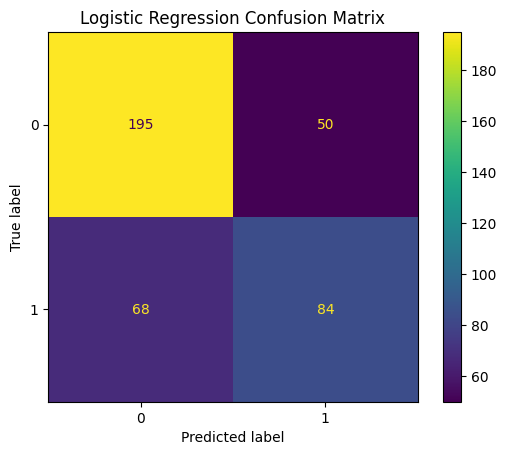

In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()


# 2nd decision tree 

Decision Tree Accuracy: 0.6322418136020151
Decision Tree ROC-AUC: 0.6071428571428571


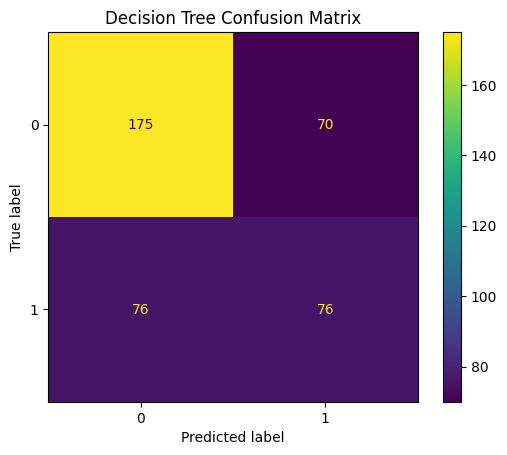

In [14]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:,1]

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree ROC-AUC:", roc_auc_score(y_test, y_proba_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()


# 3rd svm model 

SVM Accuracy: 0.690176322418136
SVM ROC-AUC: 0.745126208378088


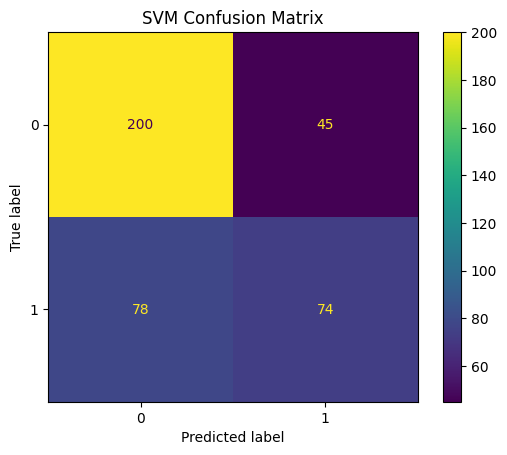

In [15]:
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:,1]

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM ROC-AUC:", roc_auc_score(y_test, y_proba_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm).plot()
plt.title("SVM Confusion Matrix")
plt.show()


# step-7 comparision of all three model on metrics , accuracy, roc-auc

                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.702771  0.744522
1        Decision Tree  0.632242  0.607143
2                  SVM  0.690176  0.745126


<Figure size 800x600 with 0 Axes>

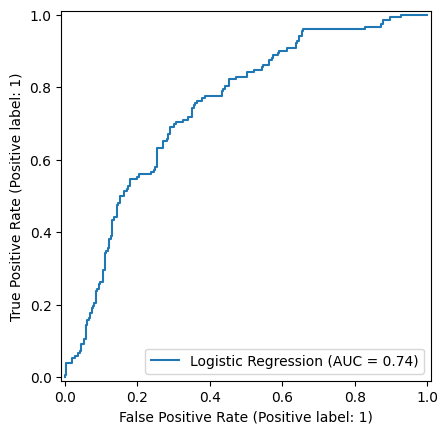

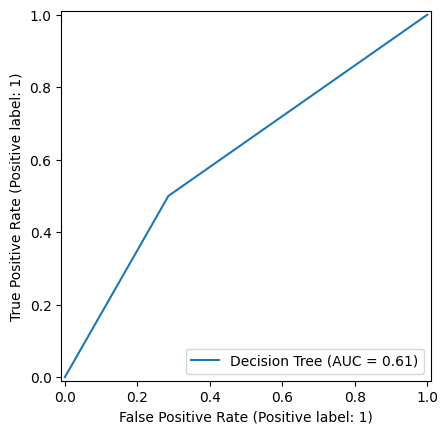

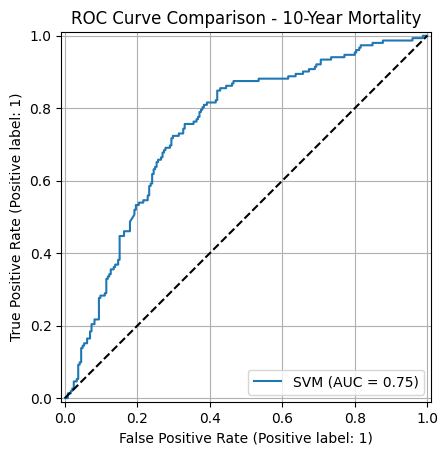

Best Model: SVM with ROC-AUC = 0.745


In [16]:
from sklearn.metrics import RocCurveDisplay

# --- 1. Collect metrics ---
metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_svm)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_svm)
    ]
})

print(metrics)

# --- 2. Plot ROC curves ---
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(lr, X_test, y_test, name='Logistic Regression')
RocCurveDisplay.from_estimator(dt, X_test, y_test, name='Decision Tree')
RocCurveDisplay.from_estimator(svm, X_test, y_test, name='SVM')
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.title("ROC Curve Comparison - 10-Year Mortality")
plt.grid(True)
plt.show()

# --- 3. Select best model ---
best_model_name = metrics.loc[metrics['ROC-AUC'].idxmax(), 'Model']
best_model_score = metrics['ROC-AUC'].max()

print(f"Best Model: {best_model_name} with ROC-AUC = {best_model_score:.3f}")


# setp-8 final model selection

# we choose logistic regression bcz it has better accuracy and roc-auc comapare to other model 

Final Model: Logistic Regression
Accuracy: 0.703
ROC-AUC: 0.745


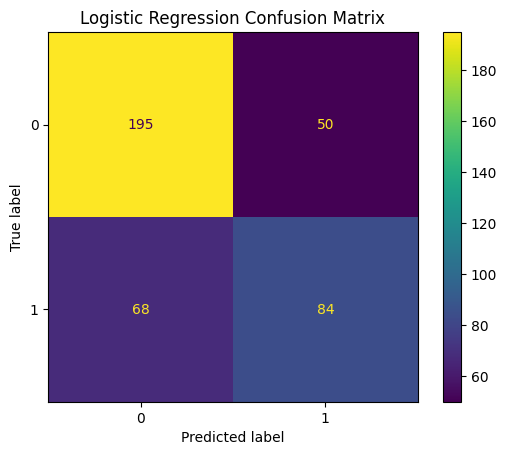

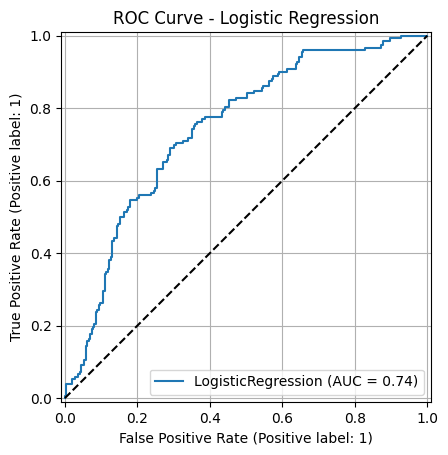

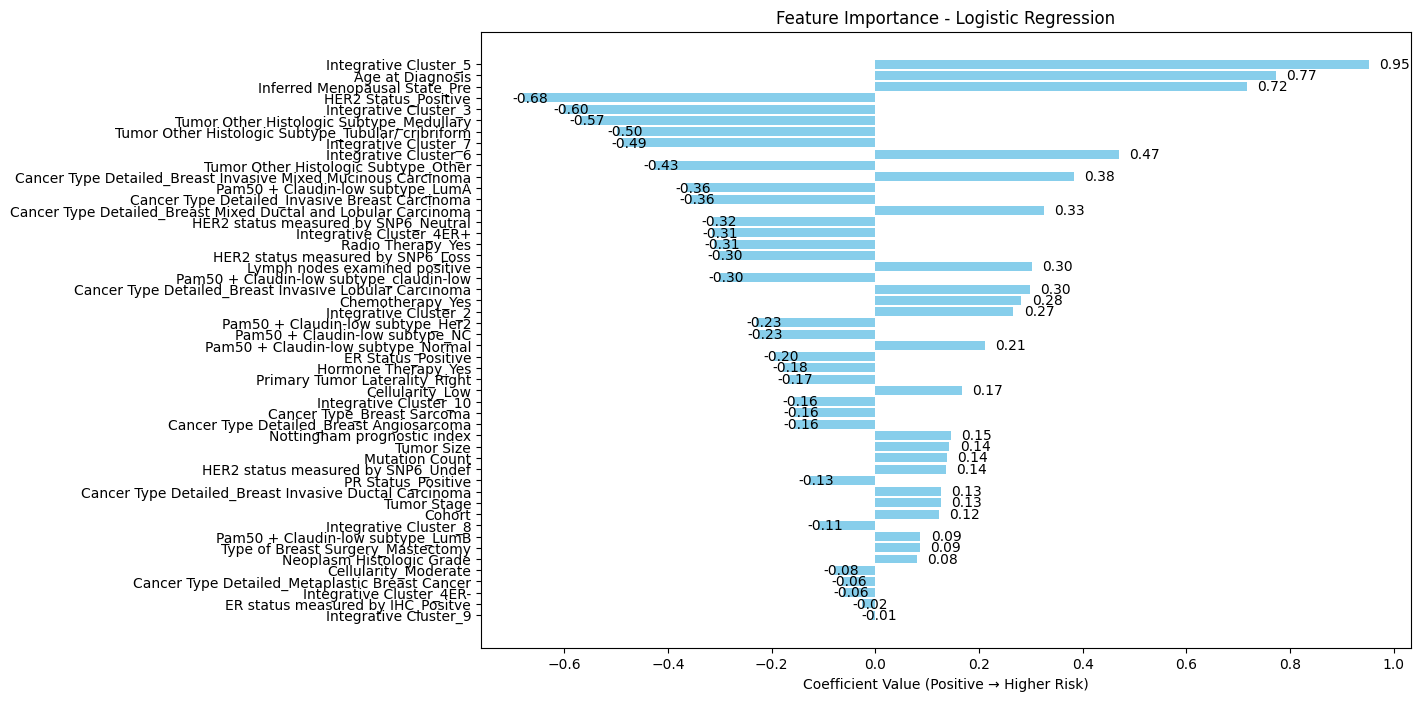

In [18]:
# --- Final Model: Logistic Regression ---
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Predict on test set
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

# --- 1. Performance Metrics ---
accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_proba_lr)

print(f"Final Model: Logistic Regression")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# --- 2. Confusion Matrix ---
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr)).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# --- 3. ROC Curve ---
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.plot([0,1],[0,1],'k--')  # diagonal reference
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.show()


# Sort features by absolute importance
importance_df = importance_df.sort_values(by='abs_importance', ascending=True)  # ascending for horizontal bar

plt.figure(figsize=(12,8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Coefficient Value (Positive → Higher Risk)")
plt.title("Feature Importance - Logistic Regression")

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02*np.sign(width), bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=10)


# final conclusion
This project successfully analyzed breast cancer survival patterns and developed a predictive model for estimating the 10-year mortality risk using the METABRIC clinical dataset. Through structured exploratory analysis, survival modeling, and machine learning techniques, several meaningful insights were obtained:

Survival Analysis Findings

The Kaplan–Meier survival curve revealed a clear decline in survival probability over the 10-year period.

The Cox Proportional Hazards model identified key clinical factors influencing mortality risk. Features such as HER2 positivity and higher histologic grade significantly increased the hazard of death, aligning with medical literature.

Predictive Modeling Results

Three classification models—Logistic Regression, Decision Tree, and SVM—were trained and evaluated on predicting 10-year mortality.

Logistic Regression performed the best with the highest ROC-AUC (~0.74) and solid accuracy, making it the most reliable model for this dataset.

Feature Importance Insights

Analysis of the top predictive features highlighted clinical markers such as Age, Tumor Size, Lymph Node count, Nottingham Prognostic Index, and HER2/ER status, indicating their strong relationship with patient outcomes.

Impact & Benefits

The findings of this project support better treatment planning, risk stratification, and patient counselling.

Understanding survival and risk factors provides clear direction for future research and may help clinicians personalize therapy decisions.

📌 Overall Summary

This project achieved all its goals:

Conducted comprehensive EDA

Performed Kaplan–Meier and CoxPH survival analysis

Built and compared multiple ML models

Identified a final optimal classifier (Logistic Regression)

Generated clinically meaningful insights

Overall, the study demonstrates that a combination of survival analysis and machine learning can effectively support breast cancer outcome prediction and contribute to improved clinical decision-making.